# Download dataset with Pytorch



## Load the data

In [93]:
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
from PIL import Image

# Define transformation for each image
transform = transforms.Compose([
  transforms.Lambda(lambda x: np.array(x).flatten()), #Stretch image into row [32,32,3] -> [3072]
])

# Download a CIFAR10 dataset
dataset = datasets.CIFAR10("content", train=True, transform=transform, download=True)
classes = ['Самолет', 'Автомобиль', 'Птица', 'Кошка', 'Олень', 'Собака', 'Лягушка', 'Лошадь', 'Корабль', 'Грузовик']

Files already downloaded and verified


## Split dataset & define dataloaders

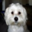

'Собака'

In [94]:
train_ds, val_ds, _= random_split(dataset, [20000, 1000, 29000])
# Hint: Perform debug on smaller subset

batch_size = 256
train_loader = DataLoader(train_ds, batch_size=batch_size)
val_loader = DataLoader(val_ds, batch_size=batch_size)

# Display one image
for images, class_nums in train_loader:
  display(Image.fromarray(images[0].reshape((32,32,3)).numpy()), classes[class_nums[0].item()]) 
  break

# Implement LinearClassifier class for CIFAR10

In [100]:
class LinearClassifier:
  def __init__(self, labels, delta=1.6, learning_rate=1e-8, reg_coef=1):
    self.labels = labels
    self.classes_num = len(labels)
    # Generate a random weight matrix of small numbers
    # You can change this code
    self.W = None
    self.delta = delta
    self.learning_rate = learning_rate
    self.reg_coef = reg_coef
  
  def train(self, x_batch, y_batch, learning_rate=None):
    """
      Arguments:
        x (numpy.array): collection of objects (batch)
        y (numpy.array): collection of integer 
        representing a class number for objects from x
    """
    x_batch = self.add_ones(x_batch)

    if self.W is None:
      self.W = np.random.randn(x_batch.shape[1], self.classes_num) * 0.0001
    if learning_rate is None:
      learning_rate = self.learning_rate

    loss_val, grad = self.loss(x_batch, y_batch)
    self.W -= (grad * learning_rate)
    return loss_val

  def loss(self, x, y):
    """
      Arguments:
        x (numpy.array): collection of objects (batch)
        y (numpy.array): collection of integer 
        representing a class number for objects from x
    """

    size = x.shape[0]

    # multiclass SVM loss
    predicted = x.dot(self.W)
    original = predicted[np.arange(size), y].reshape((size, -1))
    losses = np.maximum(0, predicted - original + self.delta)
    losses[np.arange(size), y] = 0
    loss = np.sum(losses) / size

    # gradients
    mask = (losses > 0)*1
    mask[np.arange(size), y] = -np.sum(mask, axis=1)
    dW = np.dot(x.T, mask) / size

    # regularization 
    w = self.W[:-1,:]
    loss += self.reg_coef * np.sum(w * w)
    biases = self.W[-1, :]
    dW += 2 * self.reg_coef * self.W
    dW[-1, :] = biases
    return loss, dW

  def add_ones(self, x):
    return np.hstack([x, np.ones((x.shape[0], 1))])

  def predict(self, x):
    x = self.add_ones(x)
    scores = x.dot(self.W) # (256, 3073) * (3073, 10)
    return np.argmax(scores, axis=1)


# Train model

## Function for accuracy checking

Don't change this code

In [101]:
from sklearn.metrics import accuracy_score

def validate(model, dataloader):
  y_predicted = np.array([])
  y_gtrue = np.array([])
  for images, class_nums in dataloader:
    index = model.predict(images.numpy())
    y_predicted = np.append(y_predicted, index) 
    y_gtrue = np.append(y_gtrue, class_nums.numpy()) 
  return accuracy_score(y_gtrue, y_predicted)  

## Train loop
Let's train our model

In [103]:
np.random.seed(122)
model = LinearClassifier(dataset.classes, delta=1, reg_coef=100)
best_accuracy = 0
for epoch in range(50):
  for images, class_nums in train_loader:
    loss = model.train(images.numpy(), class_nums.numpy())
    accuracy = validate(model, val_loader)
    
  best_accuracy = max(best_accuracy, accuracy)
  print(f"Epoch {epoch} Loss: {loss:.5f}, Accuracy: {accuracy}")

print(f"Best accuracy is {best_accuracy}")

Epoch 0 Loss: 6.96687, Accuracy: 0.184
Epoch 1 Loss: 6.31238, Accuracy: 0.227
Epoch 2 Loss: 5.99735, Accuracy: 0.261
Epoch 3 Loss: 5.77201, Accuracy: 0.277
Epoch 4 Loss: 5.63550, Accuracy: 0.285
Epoch 5 Loss: 5.49337, Accuracy: 0.295
Epoch 6 Loss: 5.37729, Accuracy: 0.304
Epoch 7 Loss: 5.28684, Accuracy: 0.31
Epoch 8 Loss: 5.22864, Accuracy: 0.321
Epoch 9 Loss: 5.16961, Accuracy: 0.323
Epoch 10 Loss: 5.12319, Accuracy: 0.322
Epoch 11 Loss: 5.07534, Accuracy: 0.324
Epoch 12 Loss: 5.04426, Accuracy: 0.331
Epoch 13 Loss: 5.01517, Accuracy: 0.333
Epoch 14 Loss: 4.98465, Accuracy: 0.329
Epoch 15 Loss: 4.95782, Accuracy: 0.334
Epoch 16 Loss: 4.93390, Accuracy: 0.335
Epoch 17 Loss: 4.91683, Accuracy: 0.338
Epoch 18 Loss: 4.89474, Accuracy: 0.336
Epoch 19 Loss: 4.87456, Accuracy: 0.338
Epoch 20 Loss: 4.85135, Accuracy: 0.34
Epoch 21 Loss: 4.82563, Accuracy: 0.338
Epoch 22 Loss: 4.80498, Accuracy: 0.34
Epoch 23 Loss: 4.78788, Accuracy: 0.343
Epoch 24 Loss: 4.76717, Accuracy: 0.344
Epoch 25 Loss

# Check model on test dataset

You must get accuracy above 0.35


In [104]:
test_dataset = datasets.CIFAR10("content", train=False, transform=transform, download=True)

test_loader = DataLoader(test_dataset, batch_size = batch_size)

accuracy = validate(model, test_loader)
print(f"Accuracy on test: {accuracy}")

Files already downloaded and verified
Accuracy on test: 0.3664


# Place for brief conclusion
Feel free to describe troubles here.


...



# Ideas for extra work

- Implenment CrossEntropyLoss function
- Implement bias trick ✅
- Add regularization to SVM loss ✅
- Find best learning rate and regularization strength using Cross-Validation
- Normalize data 